In [17]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import numpy as np
import time
from scipy.ndimage import uniform_filter

In [2]:
from sklearn.model_selection import train_test_split

(<matplotlib.image.AxesImage at 0x28d6499e160>, (2, 90, 58))

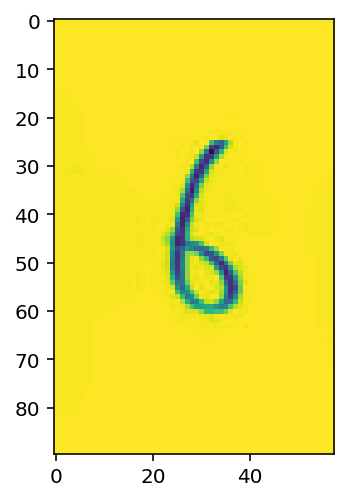

In [107]:
def read_img(file_name, color_inv_norm=True):
    """
    read a image from local file system
    :param file_name:
    :param color_inv_norm:
    :return:
    """
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

    if color_inv_norm:
        img = 255 - img

        # img = remove_back(img, np.ones((5, 5), np.uint8))

        img = img / 255.0
    else:
        img[img < 50] = 0
        img = img / 255.0

    return img

def get_data(base_path):
    """

    :param base_path:
    :return:
    """
    nums = os.listdir(base_path)
    train_data = []
    train_label = []
    lbl = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
    for num in tqdm(nums):
        calc = 0
        jpgs = os.listdir(os.path.join(base_path, num))
#         print('-' * 30, 'now load %s' % num, '-' * 30)
        for jpg in jpgs:
            # calc += 1
            # if calc > 5000:
            #     print('the %s data is more than 5000' % num)
                # break

            fname = os.path.join(base_path, num, jpg)
            pic = read_img(fname, color_inv_norm=False)
            train_data.append(pic)
            train_label.append(lbl[int(num)])

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    # print(train_data.shape, train_label.shape)
    # print(train_data)
    # print(np.argmax(train_label, axis=1))
    return train_data, train_label



In [160]:
def hog_feature_mul(im):
    """Compute Histogram of Gradient (HOG) feature for an image

         Modified from skimage.feature.hog
         http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog

       Reference:
         Histograms of Oriented Gradients for Human Detection
         Navneet Dalal and Bill Triggs, CVPR 2005

      Parameters:
        im : an input grayscale or rgb image

      Returns:
        feat: Histogram of Gradient (HOG) feature

    """
    # convert rgb to grayscale if needed
#     if im.ndim == 3:
#         image = rgb2gray(im)
#     else:
#         image = np.atleast_2d(im)
    image = im
    _, sx, sy = image.shape  # image size
    orientations = 9  # number of gradient bins
    cx, cy = (8, 8)  # pixels per cell
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :, :-1] = np.diff(image, n=1, axis=2)  # compute gradient on x-direction
    gy[:, :-1, :] = np.diff(image, n=1, axis=1)  # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2)  # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90  # gradient orientation
    print('grad_ori', grad_ori.shape)
    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((image.shape[0], n_cellsx, n_cellsy, orientations))
#     print(orientation_histogram.shape)
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        
        if i == 0:
            print('tmp_mag', uniform_filter(temp_mag, size=(1, cx, cy))[0::1, cx // 2::cx, cy // 2::cy].shape)
        
        # uniform_filter:模糊化
        orientation_histogram[:, :, :, i] = uniform_filter(temp_mag, size=(1, cx, cy))[0::1, cx // 2::cx, cy // 2::cy]
    return orientation_histogram.reshape(orientation_histogram.shape[0], -1)

In [161]:
bins = hog_feature_mul(imgs)
bins.shape

grad_ori (2, 90, 58)
tmp_mag (2, 11, 7)


(2, 693)

In [162]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')